In [57]:
import requests
from bs4 import BeautifulSoup

def download_and_extract_text(url, output_file):
    response = requests.get(url)


    if response.status_code == 200:
        soup = BeautifulSoup(response.content, 'html.parser')


        text = soup.get_text()

        with open(output_file, 'w', encoding='utf-8') as file:
            file.write(text)

        print(f"Текст успешно сохранен в файл {output_file}")
    else:
        print(f"Не удалось загрузить сайт. Код состояния: {response.status_code}")


url = 'https://bsnlp.cs.helsinki.fi/bsnlp-2019/shared_task.html'
output_file = 'output.txt'
download_and_extract_text(url, output_file)

Текст успешно сохранен в файл output.txt


In [58]:
!ls

 datasets					     gigachat_responses
 datasets-c7374a9a-7b40-5fde-934d-ec54996f44db.csv   output.txt
'datasets_with_gigachat_answers 2.csv'		     sample_data


In [59]:
import os

def search_files(directory, extension=None):
    file_list = []

    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return file_list

    if not os.path.isdir(directory):
        print(f"'{directory}' не является директорией.")
        return file_list

    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)

        try:
            if os.path.isdir(full_path):
                file_list.extend(search_files(full_path, extension))
            elif os.path.isfile(full_path):
                if extension is None or full_path.endswith(extension):
                    file_list.append(full_path)
        except PermissionError:
            print(f"Нет доступа к '{full_path}'")
        except Exception as e:
            print(f"Ошибка при обработке '{full_path}': {e}")

    return file_list

directory_to_search = '/content/datasets'
extension_filter = '.txt'

files_found = search_files(directory_to_search, extension_filter)

for file in files_found:
    print(file)

/content/datasets/brexit_ru.txt_file_1003.txt
/content/datasets/brexit_ru.txt_file_1006.txt
/content/datasets/brexit_ru.txt_file_10.txt
/content/datasets/brexit_ru.txt_file_1017.txt
/content/datasets/brexit_ru.txt_file_1004.txt
/content/datasets/brexit_ru.txt_file_1002.txt
/content/datasets/brexit_ru.txt_file_1000.txt
/content/datasets/brexit_ru.txt_file_1011.txt
/content/datasets/brexit_ru.txt_file_1001.txt


In [60]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 32.8 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [63]:
from collections import deque
import pandas as pd
import uuid
import os
import spacy

nlp = spacy.load("ru_core_news_sm")

def scan_dirs(directory, extension=None):
    file_list = deque([])

    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return file_list

    if not os.path.isdir(directory):
        print(f"'{directory}' не является директорией.")
        return file_list

    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)

        try:
            if os.path.isdir(full_path):
                file_list.extend(scan_dirs(full_path, extension))
            else:
                if extension is None or full_path.endswith(extension):
                    file_list.append(full_path)
        except PermissionError:
            print(f"Нет доступа к '{full_path}'")
        except Exception as e:
            print(f"Ошибка при обработке '{full_path}': {e}")

    return tuple(map(str, file_list))

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return ', '.join([f"{text} ({label})" for text, label in entities])

def read_text_to_dataframe(file_name):
    data = {
        'document_id': [],
        'document_text': [],
        'entity': [],
        'gold_answer': []
    }

    with open(file_name, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    if len(lines) >= 4:
        data['document_id'] = [lines[0].strip()]
        data['document_text'] = [' '.join(line.strip() for line in lines[1:])]
        data['entity'] = [lines[3].strip()]

        extracted_entities = extract_entities(data['document_text'][0])
        data['gold_answer'] = [extracted_entities]
    else:
        print(f"Недостаточно строк в файле: {file_name}")

    df = pd.DataFrame(data)

    return df

dir_search = '/content/datasets'
files_found = scan_dirs(dir_search)

print(f"Найдено файлов: {len(files_found)}")

final_df = pd.DataFrame(columns=['document_id', 'document_text', 'entity', 'gold_answer'])

for file in files_found:
    print(f"Обработка файла: {file}")
    result_df = read_text_to_dataframe(file)

    if not result_df.empty:
        final_df = pd.concat([final_df, result_df], ignore_index=True)

if final_df.empty:
    print("Финальный DataFrame пуст.")
else:
    print(final_df.head())

uni_datasets = str(uuid.uuid5(uuid.NAMESPACE_URL, dir_search))
output_file = f"/content/datasets-{uni_datasets}.csv"
final_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(f"Данные сохранены в {output_file}")

Найдено файлов: 9
Обработка файла: /content/datasets/brexit_ru.txt_file_1003.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1006.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_10.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1017.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1004.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1002.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1000.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1011.txt
Обработка файла: /content/datasets/brexit_ru.txt_file_1001.txt
  document_id                                      document_text  \
0     ru-1003  ru 2018-07-09 https://echo.msk.ru/news/2237216...   
1     ru-1006  ru 2018-07-09 http://polit.ru/news/2018/07/09/...   
2       ru-10  ru 2018-09-20 https://rg.ru/2018/09/20/tereza-...   
3     ru-1017  ru 2018-07-09 http://www.unn.com.ua/ru/news/17...   
4     ru-1004  ru 2018-07-09 http://www.aif.ru/politics/world...   

        

In [ ]:
!ls

datasets  datasets-c7374a9a-7b40-5fde-934d-ec54996f44db.csv  output.txt  sample_data


In [64]:
from collections import deque
import pandas as pd
import uuid
import os
import spacy

nlp = spacy.load("ru_core_news_sm")

def scan_dirs(directory, extension=None):
    file_list = deque([])

    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return file_list

    if not os.path.isdir(directory):
        print(f"'{directory}' не является директорией.")
        return file_list

    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)

        try:
            if os.path.isdir(full_path):
                file_list.extend(scan_dirs(full_path, extension))
            elif os.path.isfile(full_path):
                if extension is None or full_path.endswith(extension):
                    file_list.append(full_path)
        except PermissionError:
            print(f"Нет доступа к '{full_path}'")
        except Exception as e:
            print(f"Ошибка при обработке '{full_path}': {e}")

    return tuple(map(str, file_list))

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return ', '.join([f"{text} ({label})" for text, label in entities])

def read_text_to_dataframe(file_name):
    data = {
        'document_id': [],
        'document_text': [],
        'entity': [],
        'gold_answer': []
    }

    with open(file_name, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    if len(lines) >= 4:
        data['document_id'] = [lines[0].strip()]
        data['document_text'] = [' '.join(line.strip() for line in lines[1:])]

        data['entity'] = [lines[3].strip()]

        extracted_entities = extract_entities(data['document_text'][0])
        data['gold_answer'] = [extracted_entities]

    else:
        print(f"Недостаточно строк в файле: {file_name}")

    df = pd.DataFrame(data)

    return df

dir_search = '/content/datasets'
files_found = scan_dirs(dir_search)

final_df = pd.DataFrame(columns=['document_id', 'document_text', 'entity', 'gold_answer'])

for file in files_found:
    result_df = read_text_to_dataframe(file)

    if not result_df.empty:
        final_df = pd.concat([final_df, result_df], ignore_index=True)

for index, row in final_df.iterrows():
    text = row['document_text']
    entities = row['gold_answer']

    llm_input_message = f"Выдели мне сущности {entities} из этого текста: {text}"

    final_df.at[index, 'llm_input'] = llm_input_message

print(final_df[['document_id', 'llm_input']].head())

uni_datasets = str(uuid.uuid5(uuid.NAMESPACE_URL, dir_search))
output_file = f"/content/datasets-{uni_datasets}.csv"
final_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(final_df.head())
print(f"Данные сохранены в {output_file}")

  document_id                                          llm_input
0     ru-1003  Выдели мне сущности Великобритании (LOC), Бори...
1     ru-1006  Выдели мне сущности Захарова (PER), Джонсона (...
2       ru-10  Выдели мне сущности Тереза Мэй (PER), СМИ (ORG...
3     ru-1017  Выдели мне сущности Борис Джонсон (PER), Велик...
4     ru-1004  Выдели мне сущности Борис Джонсон (PER), МИД (...
  document_id                                      document_text  \
0     ru-1003  ru 2018-07-09 https://echo.msk.ru/news/2237216...   
1     ru-1006  ru 2018-07-09 http://polit.ru/news/2018/07/09/...   
2       ru-10  ru 2018-09-20 https://rg.ru/2018/09/20/tereza-...   
3     ru-1017  ru 2018-07-09 http://www.unn.com.ua/ru/news/17...   
4     ru-1004  ru 2018-07-09 http://www.aif.ru/politics/world...   

                                              entity  \
0         https://echo.msk.ru/news/2237216-echo.html   
1         http://polit.ru/news/2018/07/09/zakharova/   
2  https://rg.ru/2018/09/20/terez

In [65]:
from collections import deque
import pandas as pd
import uuid
import os
import spacy
import glob

nlp = spacy.load("ru_core_news_sm")

def scan_dirs(directory, extension=None):
    file_list = deque([])

    if not os.path.exists(directory):
        print(f"Директория '{directory}' не существует.")
        return file_list

    if not os.path.isdir(directory):
        print(f"'{directory}' не является директорией.")
        return file_list

    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)

        try:
            if os.path.isdir(full_path):
                file_list.extend(scan_dirs(full_path, extension))
            elif os.path.isfile(full_path):
                if extension is None or full_path.endswith(extension):
                    file_list.append(full_path)
        except PermissionError:
            print(f"Нет доступа к '{full_path}'")
        except Exception as e:
            print(f"Ошибка при обработке '{full_path}': {e}")

    return tuple(map(str, file_list))

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return ', '.join([f"{text} ({label})" for text, label in entities])

def read_text_to_dataframe(file_name):
    data = {
        'document_id': [],
        'document_text': [],
        'entity': [],
        'gold_answer': []
    }

    with open(file_name, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    if len(lines) >= 4:
        data['document_id'] = [os.path.basename(file_name)]
        data['document_text'] = [' '.join(line.strip() for line in lines[1:])]
        data['entity'] = [lines[3].strip()]

        extracted_entities = extract_entities(data['document_text'][0])
        data['gold_answer'] = [extracted_entities]
    else:
        print(f"Недостаточно строк в файле: {file_name}")

    df = pd.DataFrame(data)
    return df

dir_search = '/content/datasets'
files_found = scan_dirs(dir_search)

final_df = pd.DataFrame(columns=['document_id', 'document_text', 'entity', 'gold_answer'])

for file in files_found:
    result_df = read_text_to_dataframe(file)

    if not result_df.empty:
        final_df = pd.concat([final_df, result_df], ignore_index=True)

for index, row in final_df.iterrows():
    text = row['document_text']
    entities = row['gold_answer']
    llm_input_message = f"Выдели мне сущности {entities} из этого текста: {text}"
    final_df.at[index, 'llm_input'] = llm_input_message

print(final_df[['document_id', 'llm_input']].head())

uni_datasets = str(uuid.uuid5(uuid.NAMESPACE_URL, dir_search))
output_file = f"/content/datasets-{uni_datasets}.csv"
final_df.to_csv(output_file, index=False, encoding='utf-8-sig')

responses_dir = '/content/gigachat_responses'
response_files = glob.glob(os.path.join(responses_dir, '*.txt'))[:9]

gigachat_answers = []

for index, response_file in enumerate(response_files):
    with open(response_file, 'r', encoding='utf-8') as file:
        responses = [line.strip() for line in file.readlines()]

        combined_response = " ".join(responses)

        gigachat_answers.append(combined_response)

        formatted_index = index + 1

        print(f"Файл {formatted_index}: gigachat_responses({formatted_index}).txt - Содержимое: {combined_response}")

if len(gigachat_answers) < len(final_df):
    gigachat_answers += [None] * (len(final_df) - len(gigachat_answers))
elif len(gigachat_answers) > len(final_df):
    gigachat_answers = gigachat_answers[:len(final_df)]

final_df['gigachat_answer'] = gigachat_answers[:len(final_df)]

final_output_file = '/content/datasets_with_gigachat_answers.csv'
final_df.to_csv(final_output_file, index=False)
print(f"Данные с ответами сохранены в {final_output_file}")

                   document_id  \
0  brexit_ru.txt_file_1003.txt   
1  brexit_ru.txt_file_1006.txt   
2    brexit_ru.txt_file_10.txt   
3  brexit_ru.txt_file_1017.txt   
4  brexit_ru.txt_file_1004.txt   

                                           llm_input  
0  Выдели мне сущности Великобритании (LOC), Бори...  
1  Выдели мне сущности Захарова (PER), Джонсона (...  
2  Выдели мне сущности Тереза Мэй (PER), СМИ (ORG...  
3  Выдели мне сущности Борис Джонсон (PER), Велик...  
4  Выдели мне сущности Борис Джонсон (PER), МИД (...  
Файл 1: gigachat_responses(1).txt - Содержимое: **PER**: Борисом Джонсоном, Мэй - британская пресса, Бориса Джонсона, Терезы Мэй, Джонсона, Дэвид Дэвис, Терезу Мэй, Борис Джонсон, Дэвисом, Джонсоном **LOC**: Великобритании **ORG**: СМИ, Палата общин **LOC**: ЕС, Евросоюза **PER**: Мэй
Файл 2: gigachat_responses(2).txt - Содержимое: **PER**: Тереза Мэй, Мишелю Барнье, Альбиона, Джонсон, Себастьяна Курца **ORG**: СМИ, Консервативная партия, Международный валютный

In [66]:
!python -m spacy download ru_core_news_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 47.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('ru_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [67]:
import numpy as np

def score_fn(gold: str, pred: str) -> float:
    gold_set = set(gold.split())
    pred_set = set(pred.split())

    true_positives = len(gold_set.intersection(pred_set))
    false_positives = len(pred_set) - true_positives
    false_negatives = len(gold_set) - true_positives

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    if precision + recall == 0:
        return 0.0

    f1_score = 2 * (precision * recall) / (precision + recall)
    return f1_score

def test_score_fn():
    gold = "apple banana"
    pred = "banana apple"
    expected = 1.0
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

    gold = "apple banana"
    pred = "orange"
    expected = 0.0
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

    gold = "apple banana"
    pred = "banana orange"
    expected = 0.5
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

    gold = ""
    pred = ""
    expected = 0.0
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

    gold = "apple"
    pred = ""
    expected = 0.0
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

    gold = ""
    pred = "apple"
    expected = 0.0
    result = score_fn(gold, pred)
    assert np.isclose(result, expected), f"Expected {expected}, but got {result}"

test_score_fn()
print("All tests passed!")

All tests passed!


Столбцы в DataFrame: ['document_id', 'document_text', 'entity', 'gold_answer', 'llm_input', 'gigachat_answer']


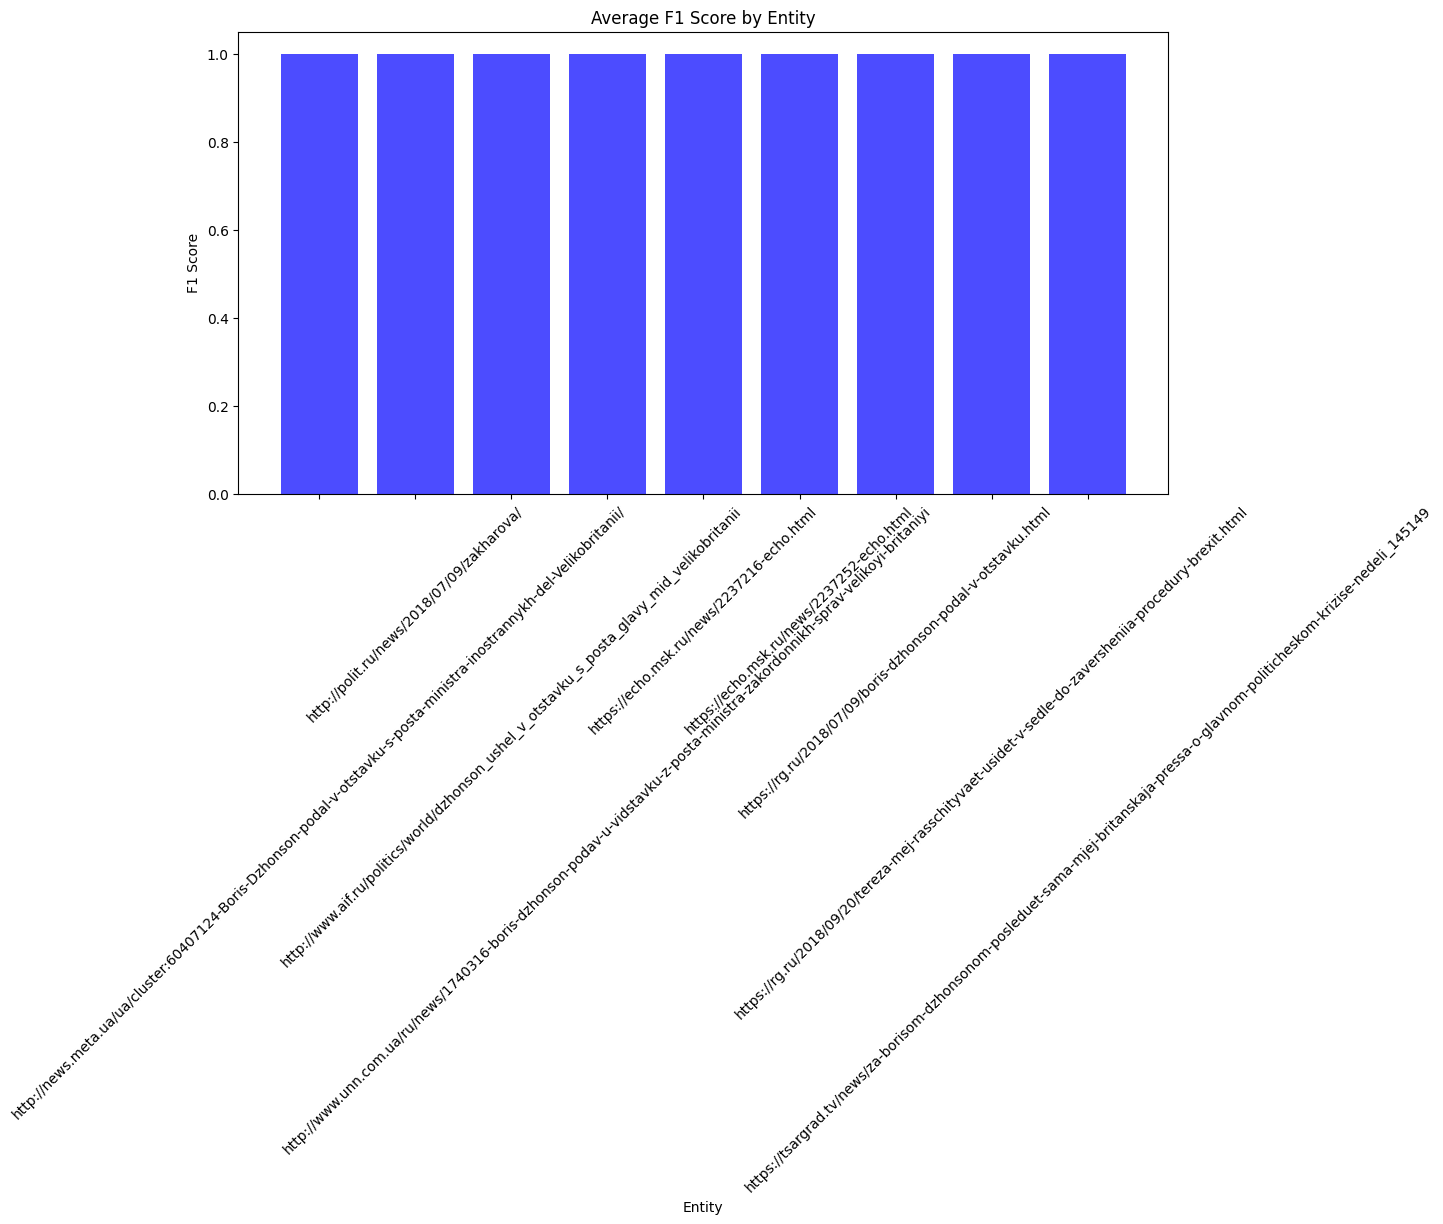

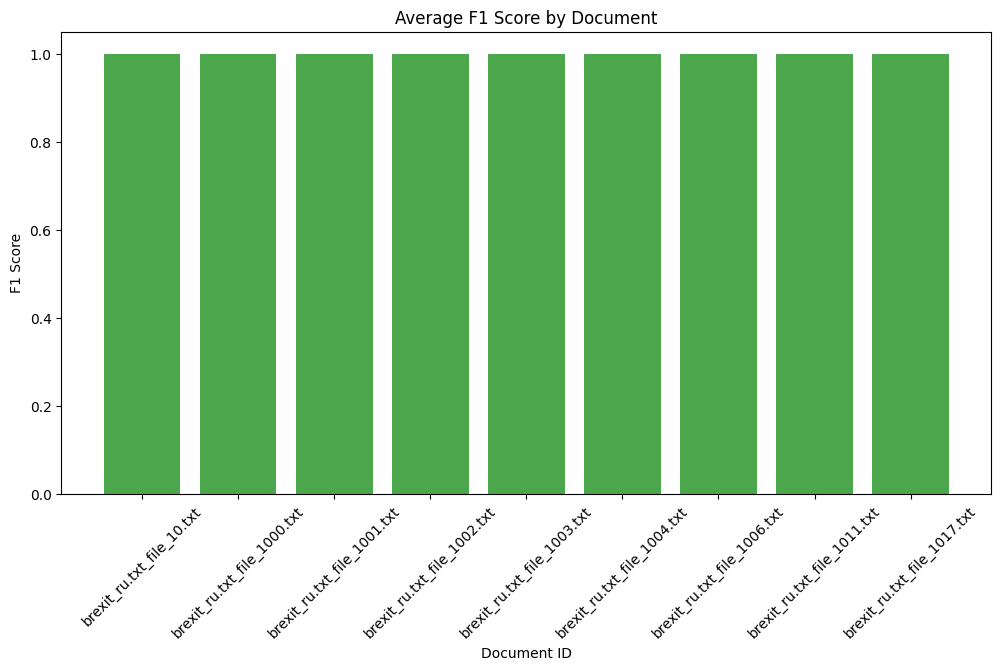

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data_path = '/content/datasets_with_gigachat_answers 2.csv'
df = pd.read_csv(data_path)

print("Столбцы в DataFrame:", df.columns.tolist())

required_columns = ['gold_answer', 'gigachat_answer', 'document_id', 'entity']
for col in required_columns:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в DataFrame.")

def calculate_metrics(gold, pred):
    true_positive = np.sum((gold == pred) & (gold == 1))
    false_positive = np.sum((gold != pred) & (pred == 1))
    false_negative = np.sum((gold != pred) & (gold == 1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

metrics_list = []

for index, row in df.iterrows():
    gold_binary = [1 if x == row['gold_answer'] else 0 for x in df['gold_answer']]
    pred_binary = [1 if x == row['gigachat_answer'] else 0 for x in df['gigachat_answer']]

    precision, recall, f1_score = calculate_metrics(np.array(gold_binary), np.array(pred_binary))

    metrics_list.append({
        'document_id': row['document_id'],
        'entity': row['entity'],
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score
    })

metrics_df = pd.DataFrame(metrics_list)

agg_results = {}

for metric in ['precision', 'recall', 'f1_score']:
    agg_results[metric] = metrics_df.groupby('entity')[metric].mean().reset_index()

agg_by_entity = agg_results['precision'].merge(agg_results['recall'], on='entity', suffixes=('_precision', '_recall'))
agg_by_entity = agg_by_entity.merge(agg_results['f1_score'], on='entity')
agg_by_entity.rename(columns={'f1_score': 'f1_score'}, inplace=True)

agg_results_doc = {}
for metric in ['precision', 'recall', 'f1_score']:
    agg_results_doc[metric] = metrics_df.groupby('document_id')[metric].mean().reset_index()

agg_by_document = agg_results_doc['precision'].merge(agg_results_doc['recall'], on='document_id', suffixes=('_precision', '_recall'))
agg_by_document = agg_by_document.merge(agg_results_doc['f1_score'], on='document_id')
agg_by_document.rename(columns={'f1_score': 'f1_score'}, inplace=True)


plt.figure(figsize=(12, 6))
plt.bar(agg_by_entity['entity'], agg_by_entity['f1_score'], color='blue', alpha=0.7)
plt.title('Average F1 Score by Entity')
plt.xlabel('Entity')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(agg_by_document['document_id'], agg_by_document['f1_score'], color='green', alpha=0.7)
plt.title('Average F1 Score by Document')
plt.xlabel('Document ID')
plt.ylabel('F1 Score')
plt.xticks(rotation=45)
plt.show()

Столбцы в DataFrame: ['document_id', 'document_text', 'entity', 'gold_answer', 'llm_input', 'gigachat_answer']


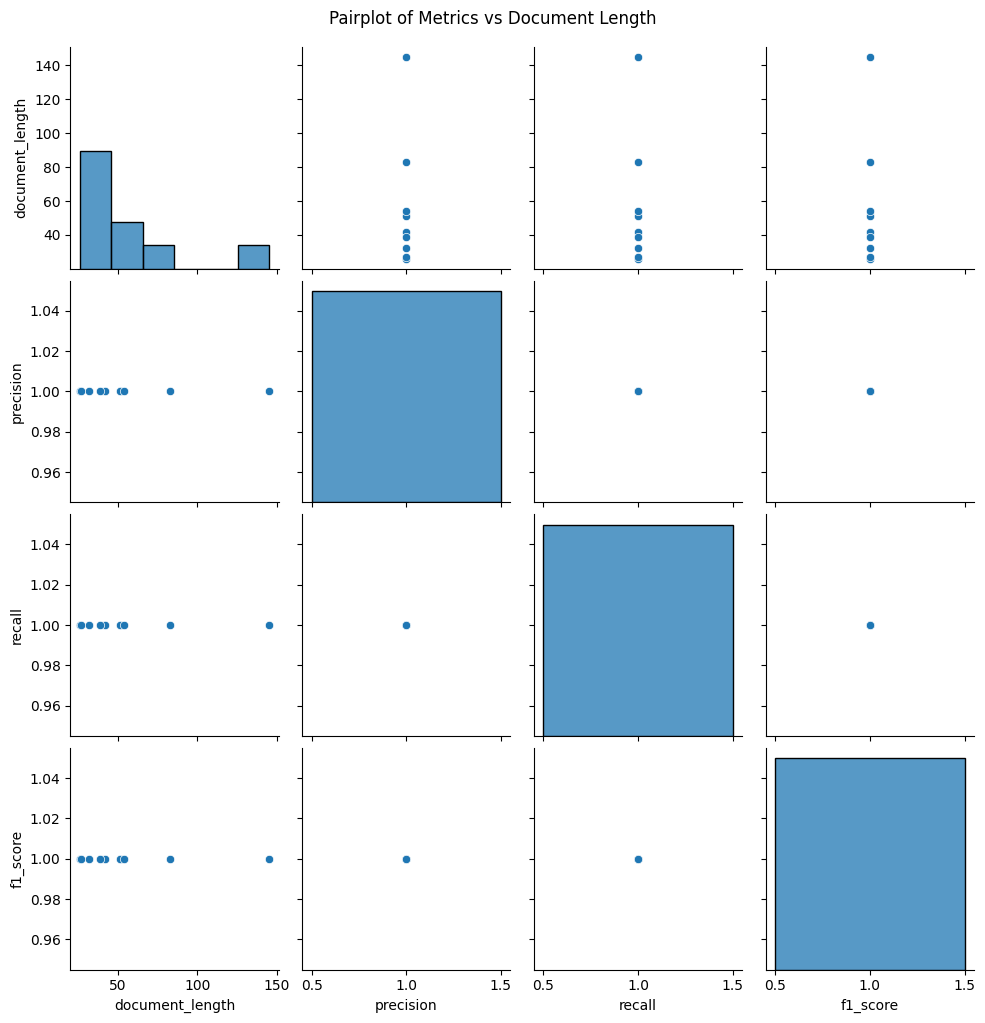

In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/datasets_with_gigachat_answers 2.csv'
df = pd.read_csv(data_path)

print("Столбцы в DataFrame:", df.columns.tolist())

required_columns = ['gold_answer', 'gigachat_answer', 'document_id', 'entity']
for col in required_columns:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в DataFrame.")

def calculate_metrics(gold, pred):
    true_positive = np.sum((gold == pred) & (gold == 1))
    false_positive = np.sum((gold != pred) & (pred == 1))
    false_negative = np.sum((gold != pred) & (gold == 1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

metrics_list = []

for index, row in df.iterrows():
    gold_binary = [1 if x == row['gold_answer'] else 0 for x in df['gold_answer']]
    pred_binary = [1 if x == row['gigachat_answer'] else 0 for x in df['gigachat_answer']]

    precision, recall, f1_score = calculate_metrics(np.array(gold_binary), np.array(pred_binary))

    document_length = len(row['gold_answer'].split())

    metrics_list.append({
        'document_id': row['document_id'],
        'entity': row['entity'],
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'document_length': document_length
    })

metrics_df = pd.DataFrame(metrics_list)

sns.pairplot(metrics_df, vars=['document_length', 'precision', 'recall', 'f1_score'])
plt.suptitle('Pairplot of Metrics vs Document Length', y=1.02)
plt.show()

Столбцы в DataFrame: ['document_id', 'document_text', 'entity', 'gold_answer', 'llm_input', 'gigachat_answer']
Статистика по ошибкам:
       precision  recall  f1_score  document_length  is_correct
count        9.0     9.0       9.0         9.000000         9.0
mean         1.0     1.0       1.0        55.444444         0.0
std          0.0     0.0       0.0        37.878461         0.0
min          1.0     1.0       1.0        26.000000         0.0
25%          1.0     1.0       1.0        32.000000         0.0
50%          1.0     1.0       1.0        42.000000         0.0
75%          1.0     1.0       1.0        54.000000         0.0
max          1.0     1.0       1.0       145.000000         0.0


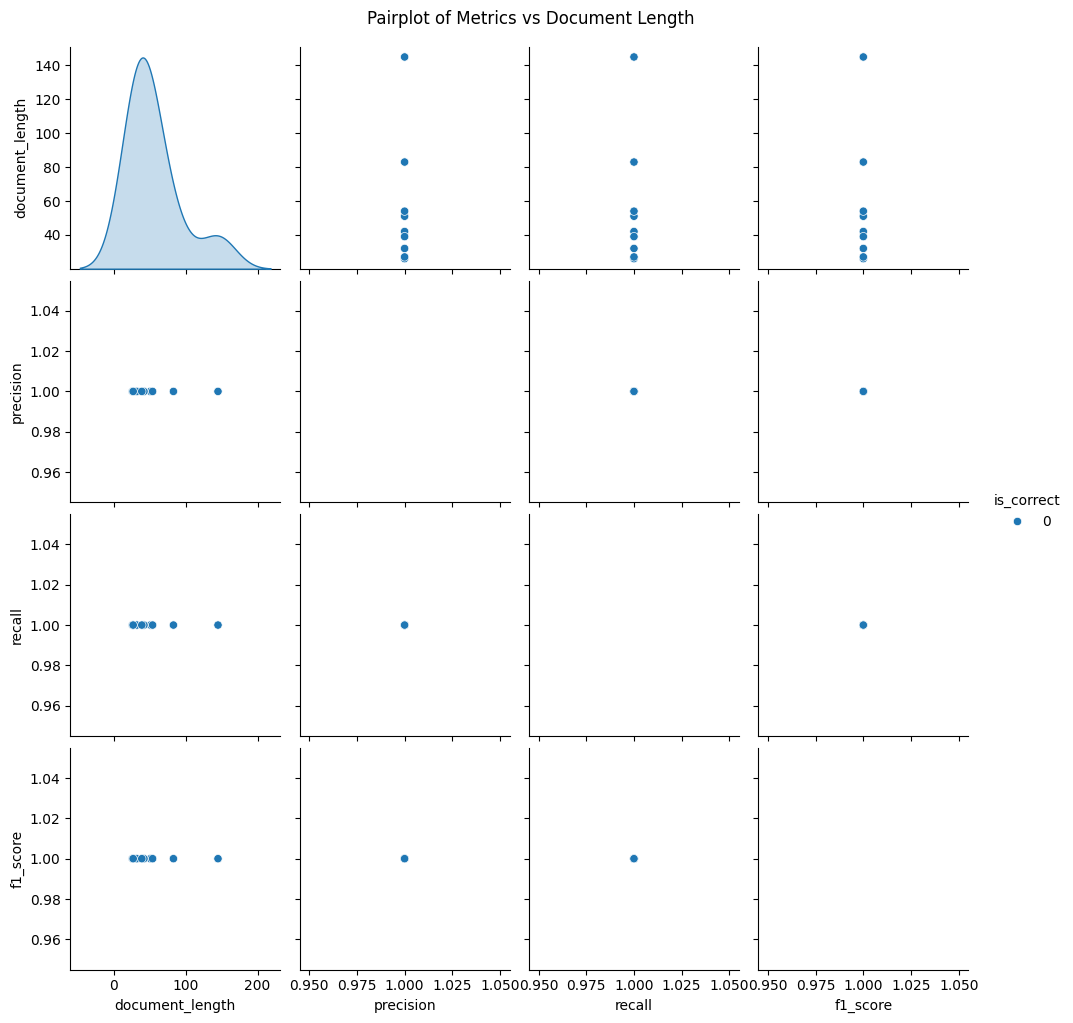

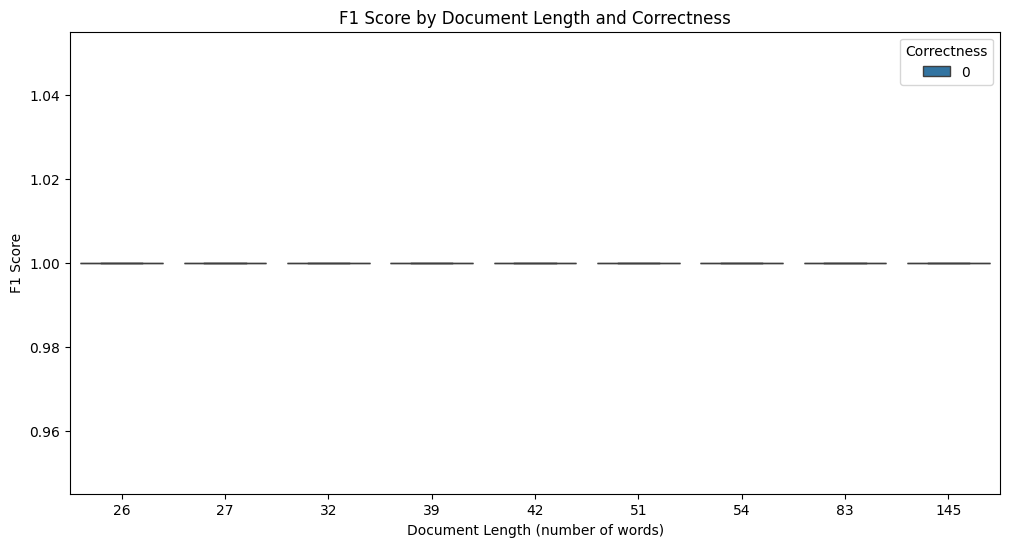

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

data_path = '/content/datasets_with_gigachat_answers 2.csv'
df = pd.read_csv(data_path)

print("Столбцы в DataFrame:", df.columns.tolist())

required_columns = ['gold_answer', 'gigachat_answer', 'document_id', 'entity']
for col in required_columns:
    if col not in df.columns:
        print(f"Столбец '{col}' не найден в DataFrame.")

def calculate_metrics(gold, pred):
    true_positive = np.sum((gold == pred) & (gold == 1))
    false_positive = np.sum((gold != pred) & (pred == 1))
    false_negative = np.sum((gold != pred) & (gold == 1))

    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return precision, recall, f1_score

metrics_list = []

for index, row in df.iterrows():
    gold_binary = [1 if x == row['gold_answer'] else 0 for x in df['gold_answer']]
    pred_binary = [1 if x == row['gigachat_answer'] else 0 for x in df['gigachat_answer']]

    precision, recall, f1_score = calculate_metrics(np.array(gold_binary), np.array(pred_binary))

    document_length = len(row['gold_answer'].split())

    is_correct = int(row['gigachat_answer'] == row['gold_answer'])

    metrics_list.append({
        'document_id': row['document_id'],
        'entity': row['entity'],
        'precision': precision,
        'recall': recall,
        'f1_score': f1_score,
        'document_length': document_length,
        'is_correct': is_correct
    })

metrics_df = pd.DataFrame(metrics_list)

error_analysis_df = metrics_df[metrics_df['is_correct'] == 0]

print("Статистика по ошибкам:")
print(error_analysis_df.describe())

sns.pairplot(metrics_df, hue='is_correct', vars=['document_length', 'precision', 'recall', 'f1_score'])
plt.suptitle('Pairplot of Metrics vs Document Length', y=1.02)
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='document_length', y='f1_score', hue='is_correct', data=metrics_df)
plt.title('F1 Score by Document Length and Correctness')
plt.xlabel('Document Length (number of words)')
plt.ylabel('F1 Score')
plt.legend(title='Correctness', loc='upper right')
plt.show()

In [81]:
import pandas as pd
import uuid
import os
import spacy

nlp = spacy.load("ru_core_news_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [(ent.text, ent.label_) for ent in doc.ents]
    return ', '.join([f"{text} ({label})" for text, label in entities])

def process_data(input_file):
    df = pd.read_csv(input_file)

    print("Столбцы в DataFrame:", df.columns.tolist())

    predictions_list = []

    for index, row in df.iterrows():
        document_id = row['document_id']
        document_text = row['document_text']
        entity = row['entity']

        extracted_entities = extract_entities(document_text)

        predictions_list.append({
            'document_id': document_id,
            'document_text': document_text,
            'entity': entity,
            'gold_answer': entity,
            'gigachat_answer': extracted_entities
        })

    predictions_df = pd.DataFrame(predictions_list)

    return predictions_df

input_file = '/content/datasets_with_gigachat_answers.csv'

predictions_df = process_data(input_file)

uni_datasets = str(uuid.uuid5(uuid.NAMESPACE_URL, input_file))
output_file = f"/content/predictions-{uni_datasets}.csv"

predictions_df.to_csv(output_file, index=False, encoding='utf-8-sig')

print(predictions_df.head())
print(f"Данные сохранены в {output_file}")

Столбцы в DataFrame: ['document_id', 'document_text', 'entity', 'gold_answer', 'llm_input', 'gigachat_answer']
                   document_id  \
0  brexit_ru.txt_file_1003.txt   
1  brexit_ru.txt_file_1006.txt   
2    brexit_ru.txt_file_10.txt   
3  brexit_ru.txt_file_1017.txt   
4  brexit_ru.txt_file_1004.txt   

                                       document_text  \
0  ru 2018-07-09 https://echo.msk.ru/news/2237216...   
1  ru 2018-07-09 http://polit.ru/news/2018/07/09/...   
2  ru 2018-09-20 https://rg.ru/2018/09/20/tereza-...   
3  ru 2018-07-09 http://www.unn.com.ua/ru/news/17...   
4  ru 2018-07-09 http://www.aif.ru/politics/world...   

                                              entity  \
0         https://echo.msk.ru/news/2237216-echo.html   
1         http://polit.ru/news/2018/07/09/zakharova/   
2  https://rg.ru/2018/09/20/tereza-mej-rasschityv...   
3  http://www.unn.com.ua/ru/news/1740316-boris-dz...   
4  http://www.aif.ru/politics/world/dzhonson_ushe...   

          